In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold

# DataBlock

In [2]:
home=os.getcwd()
home

'/users/qdb16186/dev'

# Data CV Block

to adjust CV and hyper parameter setup access:
cv_hp,
adjust test_size and shuffle split
<!--  -->


In [3]:
def path_fold(home,resample,i_fold):
    path="{}/CV/{}/fold_{}".format(os.getcwd(),resample,i_fold)
        
    # Define the directory path
    directory_path = Path(f"{home}/CV/{resample}/{i_fold}")
    
    # Ensure the directory exists, create it if necessary
    directory_path.mkdir(parents=True, exist_ok=True)

    return directory_path

def path_resample(home,resample):
    path="{}/CV/{}/".format(os.getcwd(),resample)
        
    # Define the directory path
    directory_path = Path(f"{home}/CV/{resample}")
    
    # Ensure the directory exists, create it if necessary
    directory_path.mkdir(parents=True, exist_ok=True)

    return directory_path

def cv_hp(df,home):
    resample_split  = ShuffleSplit(50, test_size=0.3, random_state=1)
    fold_split      = ShuffleSplit(5 , test_size=0.3, random_state=1)
    train_val_split = ShuffleSplit(1 , test_size=0.3, random_state=1)
    
    for resample, (train_val_index, test_index) in enumerate(resample_split.split(df)):
        train_val = pd.DataFrame(df['ID'].iloc[train_val_index])
        test = pd.DataFrame(df['ID'].iloc[test_index])
        for i, (train_index, val_index) in enumerate(train_val_split.split(train_val)):
            train = pd.DataFrame(df['ID'].iloc[train_index])
            val   = pd.DataFrame(df['ID'].iloc[val_index])
        resample_path = path_resample(home,resample)
        train.to_csv(f'{resample_path}/train.csv')
        val.to_csv(f'{resample_path}/val.csv')
        test.to_csv(f'{resample_path}/test.csv')
        # train,val,test to_csv
        for i_fold, (train_val_fold_index, test_fold_index) in enumerate(fold_split.split(train)):
            train_val_fold = pd.DataFrame(train['ID'].iloc[train_val_fold_index])
            test_fold = pd.DataFrame(train['ID'].iloc[test_fold_index])
            for i, (train_fold_index, val_fold_index) in enumerate(train_val_split.split(train_val_fold)):
                train_fold = pd.DataFrame(train_val_fold['ID'].iloc[train_fold_index])
                val_fold   = pd.DataFrame(train_val_fold['ID'].iloc[val_fold_index])
            i_fold_path = path_fold(home,resample,i_fold)
            train_fold.to_csv(f'{i_fold_path}/train.csv')
            val_fold.to_csv(f'{i_fold_path}/val.csv')
            test_fold.to_csv(f'{i_fold_path}/test.csv')
            

    return print("data organised into 50 CV with 5-fold inner CV")



In [4]:
df=pd.read_csv("Lomzov_dataset_IY.csv")
home=os.getcwd()
# pathlib.Path("Lomzov_dataset_IY.csv").parent.absolute()
cv_hp(df,home)

data organised into 50 CV with 5-fold inner CV


# Accessing Data Via ID CV and full table

In [5]:
def access_fold_csv(df,home,resample,fold):
    df_path = path_fold(home,resample,fold)
    train_df=pd.read_csv(f'{df_path}/train.csv')
    val_df=pd.read_csv(f'{df_path}/val.csv')
    test_df=pd.read_csv(f'{df_path}/test.csv')

    train_df=df[df["ID"].isin(train_df['ID'])]
    val_df=df[df["ID"].isin(val_df['ID'])]
    test_df=df[df["ID"].isin(test_df['ID'])]
    return train_df, val_df, test_df


def access_resample_csv(df,home,resample):
    df_path = path_resample(home,resample)
    train_df=pd.read_csv(f'{df_path}/train.csv')
    val_df=pd.read_csv(f'{df_path}/val.csv')
    test_df=pd.read_csv(f'{df_path}/test.csv')

    train_df=df[df["ID"].isin(train_df['ID'])]
    val_df=df[df["ID"].isin(val_df['ID'])]
    test_df=df[df["ID"].isin(test_df['ID'])]
    return train_df, val_df, test_df

In [6]:
resample=1
fold=1
train_fold, val_fold, test_fold = access_resample_csv(df,home,resample)

In [7]:
print(train_fold.shape, val_fold.shape, test_fold.shape)
# train_fold.shape
print(train_fold.shape[0] + val_fold.shape[0] + test_fold.shape[0])
# train_fold.shape

(149, 383) (64, 383) (92, 383)
305


# Load X, Y

## Def Functions

In [8]:
def padding(X_descr_train_scaled):
#     Padding function so X data is always 250 dimensions
# Must be coupled with load_data. NB! double check if the scalling is not affected
# https://www.geeksforgeeks.org/python-call-function-from-another-function/
    a=X_descr_train_scaled.to_numpy()
    b=np.zeros((len(X_descr_train_scaled), 
                (250-int(X_descr_train_scaled.to_numpy().shape[1]))
               )
              )
    padded=np.concatenate((a,b),
                           axis=1, 
                          out=None, 
                          dtype=None
                         )
    return padded


def load_xy(file,desc):
    # Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()

    Y = file[['dH','dS','dG','Tm']].copy()
    # Convert y data into required input shape
    y_1 = y_1.to_numpy()
    y_1 = y_1.reshape(y_1.shape[0])
    y_2 = y_2.to_numpy()
    y_2 = y_2.reshape(y_2.shape[0])
    y_3 = y_3.to_numpy()
    y_3 = y_3.reshape(y_3.shape[0])
    y_4 = y_4.to_numpy()
    y_4 = y_4.reshape(y_4.shape[0])
    
    # Load features based on prop
    X = file[[col for col in file.columns if f'{desc}_'in col]]
    
    return y_1, y_2, y_3, y_4, Y, padding(X), X

    

    

## Variables

In [9]:
df=pd.read_csv("Lomzov_dataset_IY.csv")
home=os.getcwd()
# pathlib.Path("Lomzov_dataset_IY.csv").parent.absolute()
cv_hp(df,home)

resample=1
fold=1
train, val, test = access_resample_csv(df,home,resample)
train_fold, val_fold, test_fold = access_fold_csv(df,home,resample,fold)

desc='Granulated'
y_1_train, y_2_train, y_3_train, y_4_train, Y_train, X_padded_train, X_train = load_xy(train_fold,desc)
y_1_val,   y_2_val,   y_3_val,   y_4_val,   Y_val,   X_padded_val,   X_val   = load_xy(val_fold,desc)
y_1_test,  y_2_test,  y_3_test,  y_4_test,  Y_test,  X_padded_test,  X_test  = load_xy(test_fold,desc)


data organised into 50 CV with 5-fold inner CV


# Model

In [10]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers, models, initializers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

2024-04-20 10:44:16.315269: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-20 10:44:17.156278: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-20 10:44:17.156976: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 10:44:23.114909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
def r2_func(y_true, y_pred, **kwargs):
    return metrics.r2_score(y_true, y_pred)
def rmse_func(y_true, y_pred, **kwargs):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))  
def bias_func(y_true, y_pred, **kwargs):
    return np.mean(y_true-y_pred)
def sdep_func(y_true, y_pred, **kwargs):
    return (np.mean((y_true-y_pred-(np.mean(y_true-y_pred)))**2))**0.5
#these 4 are for tensorflow formats
def r2_func_tf(y_true, y_pred, **kwargs):
    numerator = tf.reduce_sum(tf.square(y_true - y_pred))
    denominator = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - numerator / denominator
    return r2
def rmse_func_tf(y_true, y_pred, **kwargs):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    rmse = tf.sqrt(mse)
    return rmse
def bias_func_tf(y_true, y_pred, **kwargs):
    bias = tf.reduce_mean(y_true - y_pred)
    return bias
def sdep_func_tf(y_true, y_pred, **kwargs):
    diff = y_true - y_pred
    mean_diff = tf.reduce_mean(diff)
    sdep = tf.sqrt(tf.reduce_mean(tf.square(diff - mean_diff)))
    return sdep

## Model with hyper parameters

In [129]:

def build_model(hp):
    
#     Hyper parameters         
    model_type1 = hp.Choice("model_type1", ["CNN3","CNN2","CNN1"])
    model_type = hp.Choice("model_type", ["Dense3"])
 
    
#     INPUT for NN
    
    inputs = keras.Input(shape=(250,1))
    x_layer=inputs
    
#     MANDATORY CNN (optional to move into first condition hp.cond_scope
    # with hp.conditional_scope("model_type1", ["CNN0"]):
    #         if model_type1 == "CNN0":
    #             pass
#     CONDITIONAL CONVOLUTION LAYERS (Consider moving the above into CNN1) test 0-3 CNN and 0-3 Dense
    with hp.conditional_scope("model_type1", ["CNN1","CNN2""CNN3"]):
            if model_type1 != "CNN0":
                x_layer = keras.layers.Conv1D(32, 
                        kernel_size=(3), 
                        strides=(2), 
                        padding='valid', 
                        activation='relu', 
                        input_shape=(250,1),
                        name = 'conv1d_1'
                        )(x_layer)
                x_layer = keras.layers.MaxPooling1D((2), name = 'maxpooling_1')(x_layer)
                x_layer = keras.layers.BatchNormalization(name = 'batchnorm_1')(x_layer)
                pass
                
            if model_type1 != "CNN1":
                x_layer = keras.layers.Conv1D(32, 
                                    kernel_size=(3), 
                                    strides=(2), 
                                    padding='valid', 
                                    activation='relu', 
                                    name = f'conv1d_2'
                                    )(x_layer)
                x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x_layer)
                x_layer = keras.layers.BatchNormalization(name = f'batchnorm_2')(x_layer)

            if model_type1 != "CNN1" or "CNN2":               
                x_layer = keras.layers.Conv1D(32, 
                                    kernel_size=(3), 
                                    strides=(2), 
                                    padding='valid', 
                                    activation='relu', 
                                    name = f'conv1d_3'
                                    )(x_layer)
                x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_3')(x_layer)
                x_layer = keras.layers.BatchNormalization(name = f'batchnorm_3')(x_layer)
                
#     FLATTEN AFTER CONVOLUTIONS
    x_layer = keras.layers.Flatten(name = 'flatten')(x_layer)
    
#     CONDITIONAL DENSE LAYERS
    # with hp.conditional_scope("model_type", ["Dense0"]):
    #     if model_type == "Dense0":
    #         pass
            
    with hp.conditional_scope("model_type", ["Dense3"]): #["Dense1","Dense2","Dense3"]
        if model_type != "Dense0":
            hp_layer_1= hp.Choice(f'layer_1', values=[16,32,64,128])

            x_layer = keras.layers.Dense(
                        hp_layer_1,
                        activation='relu',
                        use_bias=True,
                        # name='layer_1',
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x_layer)
        if model_type != "Dense1":
            hp_layer_2_2= hp.Choice(f'layer_2_2', values=[16,32,64,128])

            x_layer = keras.layers.Dense(
                        hp_layer_2_2,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x_layer)

        if model_type != "Dense1" or "Dense2":
            hp_layer_3_3= hp.Choice(f'layer_3_3',  values=[16,32,64])
            
            x_layer = keras.layers.Dense(
                        hp_layer_3_3,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x_layer)
#     OUTPUT LAYERS

    # output_1 = keras.layers.Dense(1, name='enthalpy_pred')(x_layer)
    # output_2 = keras.layers.Dense(1, name='entropy_pred')(x_layer)
    # output_3 = keras.layers.Dense(1, name='free_energy_pred')(x_layer)
    # output_4 = keras.layers.Dense(1, name='melting_temperature')(x_layer)

    # output_1 = keras.layers.Dense(1, name='dH')(x_layer)
    # output_2 = keras.layers.Dense(1, name='dS')(x_layer)
    # output_3 = keras.layers.Dense(1, name='dG')(x_layer)
    # output_4 = keras.layers.Dense(1, name='Tm')(x_layer)
    

    # model = Model(inputs=inputs, outputs=[output_1, output_2, output_3, output_4])
    output_1 = keras.layers.Dense(1, name='output')(x_layer)
    model = Model(inputs=inputs, outputs=output_1)
    
#     SETTINGS
#     SETTINGS


    return model

## Model without hyper parameters

In [131]:

def build_model(hp=0):
     
#     INPUT for NN
    
    inputs = keras.Input(shape=(250,1))
    x_layer=inputs
    
    # Conv layer 1
    x_layer = keras.layers.Conv1D(32, 
            kernel_size=(3), 
            strides=(2), 
            padding='valid', 
            activation='relu', 
            input_shape=(250,1),
            name = 'conv1d_1'
            )(x_layer)
    x_layer = keras.layers.MaxPooling1D((2), name = 'maxpooling_1')(x_layer)
    x_layer = keras.layers.BatchNormalization(name = 'batchnorm_1')(x_layer)



    # Conv layer 2
    x_layer = keras.layers.Conv1D(32, 
                        kernel_size=(3), 
                        strides=(2), 
                        padding='valid', 
                        activation='relu', 
                        name = f'conv1d_2'
                        )(x_layer)
    x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x_layer)
    x_layer = keras.layers.BatchNormalization(name = f'batchnorm_2')(x_layer)


    # Conv layer 3
    x_layer = keras.layers.Conv1D(32, 
                        kernel_size=(3), 
                        strides=(2), 
                        padding='valid', 
                        activation='relu', 
                        name = f'conv1d_3'
                        )(x_layer)
    x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_3')(x_layer)
    x_layer = keras.layers.BatchNormalization(name = f'batchnorm_3')(x_layer)
                
#     FLATTEN AFTER CONVOLUTIONS
    x_layer = keras.layers.Flatten(name = 'flatten')(x_layer)
    
    
    #Node 1
    node1_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node1_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node1_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node1_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node1_layer)


    node1_layer = keras.layers.Dense(
                16,
                activation='relu',
                name='node1_3',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node1_layer)
    
    
    #Node 2
    node2_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node2_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node2_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node2_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node2_layer)


    node2_layer = keras.layers.Dense(
                16,
                activation='relu',
                name='node2_3',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node2_layer)
    
    #Node 3
    node3_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node3_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node3_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node3_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node3_layer)


    node3_layer = keras.layers.Dense(
                16,
                activation='relu',
                name='node3_3',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node3_layer)
    
    #Node 4
    node4_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node4_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node4_layer = keras.layers.Dense(
                32,
                activation='relu',
                use_bias=True,
                name='node4_2',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node4_layer)


    node4_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node4_3',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node4_layer)
#     OUTPUT LAYERS

    # output_1 = keras.layers.Dense(1, name='enthalpy_pred')(x_layer)
    # output_2 = keras.layers.Dense(1, name='entropy_pred')(x_layer)
    # output_3 = keras.layers.Dense(1, name='free_energy_pred')(x_layer)
    # output_4 = keras.layers.Dense(1, name='melting_temperature')(x_layer)

    output_1 = keras.layers.Dense(1, name='dH')(node1_layer)
    output_2 = keras.layers.Dense(1, name='dS')(node2_layer)
    output_3 = keras.layers.Dense(1, name='dG')(node3_layer)
    output_4 = keras.layers.Dense(1, name='Tm')(node4_layer)
    

    model = Model(inputs=inputs, outputs=[output_1, output_2, output_3, output_4])
    # output_1 = keras.layers.Dense(1, name='output')(x_layer)
    # model = Model(inputs=inputs, outputs=output_1)
    
#     SETTINGS

# #     ADAPTIVE LEARNING RATE   
    
#     initial_learning_rate = 0.01
#     decay_steps = 10.0
#     decay_rate = 0.5
#     learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
#                                     initial_learning_rate, decay_steps, decay_rate)
    
# #     SETTING ADAM OPTIMISER
#     optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
    
# #     COMPILE MODEl
#     model.compile(loss = "mse" , 
#                   optimizer = optimiser, 
#                   metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
    
    return model

### 2CNN 2NN

In [132]:

def build_model(hp=0):
     
#     INPUT for NN
    
    inputs = keras.Input(shape=(250,1))
    x_layer=inputs
    
    # Conv layer 1
    x_layer = keras.layers.Conv1D(32, 
            kernel_size=(3), 
            strides=(2), 
            padding='valid', 
            activation='relu', 
            input_shape=(250,1),
            name = 'conv1d_1'
            )(x_layer)
    x_layer = keras.layers.MaxPooling1D((2), name = 'maxpooling_1')(x_layer)
    x_layer = keras.layers.BatchNormalization(name = 'batchnorm_1')(x_layer)



    # Conv layer 2
    x_layer = keras.layers.Conv1D(32, 
                        kernel_size=(3), 
                        strides=(2), 
                        padding='valid', 
                        activation='relu', 
                        name = f'conv1d_2'
                        )(x_layer)
    x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x_layer)
    x_layer = keras.layers.BatchNormalization(name = f'batchnorm_2')(x_layer)


    # # Conv layer 3
    # x_layer = keras.layers.Conv1D(32, 
    #                     kernel_size=(3), 
    #                     strides=(2), 
    #                     padding='valid', 
    #                     activation='relu', 
    #                     name = f'conv1d_3'
    #                     )(x_layer)
    # x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_3')(x_layer)
    # x_layer = keras.layers.BatchNormalization(name = f'batchnorm_3')(x_layer)
                
#     FLATTEN AFTER CONVOLUTIONS
    x_layer = keras.layers.Flatten(name = 'flatten')(x_layer)
    
    
    #Node 1
    node1_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node1_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node1_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node1_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node1_layer)


    # node1_layer = keras.layers.Dense(
    #             16,
    #             activation='relu',
    #             name='node1_3',
    #             use_bias=True,
    #             kernel_initializer='glorot_uniform',
    #             bias_initializer='zeros',
    #             kernel_regularizer=None,
    #             bias_regularizer=None,
    #             activity_regularizer=None,
    #             kernel_constraint=None,
    #             bias_constraint=None
    #         )(node1_layer)
    
    
    #Node 2
    node2_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node2_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node2_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node2_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node2_layer)


    # node2_layer = keras.layers.Dense(
    #             16,
    #             activation='relu',
    #             name='node2_3',
    #             use_bias=True,
    #             kernel_initializer='glorot_uniform',
    #             bias_initializer='zeros',
    #             kernel_regularizer=None,
    #             bias_regularizer=None,
    #             activity_regularizer=None,
    #             kernel_constraint=None,
    #             bias_constraint=None
    #         )(node2_layer)
    
    #Node 3
    node3_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node3_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node3_layer = keras.layers.Dense(
                32,
                activation='relu',
                name='node3_2',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node3_layer)


    # node3_layer = keras.layers.Dense(
    #             16,
    #             activation='relu',
    #             name='node3_3',
    #             use_bias=True,
    #             kernel_initializer='glorot_uniform',
    #             bias_initializer='zeros',
    #             kernel_regularizer=None,
    #             bias_regularizer=None,
    #             activity_regularizer=None,
    #             kernel_constraint=None,
    #             bias_constraint=None
    #         )(node3_layer)
    
    #Node 4
    node4_layer = keras.layers.Dense(
                16,
                activation='relu',
                use_bias=True,
                name='node4_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x_layer)

    node4_layer = keras.layers.Dense(
                32,
                activation='relu',
                use_bias=True,
                name='node4_2',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(node4_layer)


    # node4_layer = keras.layers.Dense(
    #             16,
    #             activation='relu',
    #             use_bias=True,
    #             name='node4_3',
    #             kernel_initializer='glorot_uniform',
    #             bias_initializer='zeros',
    #             kernel_regularizer=None,
    #             bias_regularizer=None,
    #             activity_regularizer=None,
    #             kernel_constraint=None,
    #             bias_constraint=None
    #         )(node4_layer)
#     OUTPUT LAYERS

    # output_1 = keras.layers.Dense(1, name='enthalpy_pred')(x_layer)
    # output_2 = keras.layers.Dense(1, name='entropy_pred')(x_layer)
    # output_3 = keras.layers.Dense(1, name='free_energy_pred')(x_layer)
    # output_4 = keras.layers.Dense(1, name='melting_temperature')(x_layer)

    output_1 = keras.layers.Dense(1, name='dH')(node1_layer)
    output_2 = keras.layers.Dense(1, name='dS')(node2_layer)
    output_3 = keras.layers.Dense(1, name='dG')(node3_layer)
    output_4 = keras.layers.Dense(1, name='Tm')(node4_layer)
    

    model = Model(inputs=inputs, outputs=[output_1, output_2, output_3, output_4])
    # output_1 = keras.layers.Dense(1, name='output')(x_layer)
    # model = Model(inputs=inputs, outputs=output_1)
    
#     SETTINGS

# #     ADAPTIVE LEARNING RATE   
    
#     initial_learning_rate = 0.01
#     decay_steps = 10.0
#     decay_rate = 0.5
#     learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
#                                     initial_learning_rate, decay_steps, decay_rate)
    
# #     SETTING ADAM OPTIMISER
#     optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
    
# #     COMPILE MODEl
#     model.compile(loss = "mse" , 
#                   optimizer = optimiser, 
#                   metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
    
    return model

## Initiaalise the model

In [14]:
epochs = 2
batch  = 16
# TODO: Use path lib to create path
fold_path = path_fold(home,resample,fold)
resample_path = path_resample(home,resample)

# model_name = architecture of - Single task/RF/KNN + dH/dG/dS/Tm or - Multitask  
prop = 'HGST' 
model_name = f"1DConv_mt_{prop}" 


# Define the directory path
directory_path = Path(f"{fold_path}/{desc}/{model_name}/")

tunner_path      = Path(f'{directory_path}/tunner')
csv_logger_path  = Path(f'{directory_path}/csv_logger/')
cp_callback_path = Path(f'{directory_path}/model_checkpoint/')
tensorboard_path = Path(f'{directory_path}/tensorboard_logs/')

# Ensure the directory exists, create it if necessary
tunner_path.mkdir(parents=True, exist_ok=True)
csv_logger_path.mkdir(parents=True, exist_ok=True)
cp_callback_path.mkdir(parents=True, exist_ok=True)
tensorboard_path.mkdir(parents=True, exist_ok=True)


tuner = kt.GridSearch(build_model,
                   objective=kt.Objective('val_loss', 'min'),
                    # loss = 'val_loss',
                   # objective = ['val_mse','val_free_energy_pred_mse'],
                  directory=tunner_path,
                  overwrite=False,
                  project_name=f'{batch}')

with open(f'{tunner_path}/tuner_path.txt', 'w') as f:
    f.write(tuner.project_dir)
f.close

#### CALL BACKS!
es = EarlyStopping(monitor      = 'val_loss', 
                        mode     = 'min', 
                        verbose  = 1, 
                        patience = 2000, 
                    restore_best_weights = True)
# CSV Logger
csv_logger = CSVLogger(f'{csv_logger_path}/model_history.csv' , append=True)

# CP_callbacks      not required when using a tunner       
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{cp_callback_path}/cp.ckpt',
#                                                  save_weights_only=True,
#                                                  verbose=1)

# TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path, 
                                                       #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                      update_freq = 1,
                                                      # histogram_freq=1, 
                                                      write_graph=False, 
                                                      write_images=False)
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

# Covert to list and provide to Keras Regressor
keras_callbacks = [es, csv_logger, tensorboard_callback]


# history=tuner.search(x_hp_train, y_hp_train[:],
#             epochs = epochs,
#             batch_size=batch,
#             verbose = 2,
#             validation_data =(x_hp_val, y_hp_val[:]),
#              # validation_split = 0.2,
#             callbacks=keras_callbacks)

Reloading Tuner from /users/qdb16186/dev/CV/1/1/Granulated/1DConv_mt_HGST/tunner/16/tuner0.json


## Tuning

In [15]:
y_1_train, y_2_train, y_3_train, y_4_train, Y_train, X_padded_train, X_train = load_xy(train_fold,desc)
y_1_val,   y_2_val,   y_3_val,   y_4_val,   Y_val,   X_padded_val,   X_val   = load_xy(val_fold,desc)
y_1_test,  y_2_test,  y_3_test,  y_4_test,  Y_test,  X_padded_test,  X_test  = load_xy(test_fold,desc)

In [16]:
# X_test

In [17]:
model = build_model()
history = model.fit(X_padded_train, [y_1_train, y_2_train, y_3_train, y_4_train],
                    epochs=600,
                    batch_size=16, 
                    validation_data=(X_padded_val, [y_1_val,   y_2_val,   y_3_val,   y_4_val]),
                    verbose = 3,
                    callbacks=keras_callbacks)

2024-04-20 10:44:31.858602: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/600
Epoch 2/600
Epoch 3/600
Epoch 4/600
Epoch 5/600
Epoch 6/600
Epoch 7/600
Epoch 8/600
Epoch 9/600
Epoch 10/600
Epoch 11/600
Epoch 12/600
Epoch 13/600
Epoch 14/600
Epoch 15/600
Epoch 16/600
Epoch 17/600
Epoch 18/600
Epoch 19/600
Epoch 20/600
Epoch 21/600
Epoch 22/600
Epoch 23/600
Epoch 24/600
Epoch 25/600
Epoch 26/600
Epoch 27/600
Epoch 28/600
Epoch 29/600
Epoch 30/600
Epoch 31/600
Epoch 32/600
Epoch 33/600
Epoch 34/600
Epoch 35/600
Epoch 36/600
Epoch 37/600
Epoch 38/600
Epoch 39/600
Epoch 40/600
Epoch 41/600
Epoch 42/600
Epoch 43/600
Epoch 44/600
Epoch 45/600
Epoch 46/600
Epoch 47/600
Epoch 48/600
Epoch 49/600
Epoch 50/600
Epoch 51/600
Epoch 52/600
Epoch 53/600
Epoch 54/600
Epoch 55/600
Epoch 56/600
Epoch 57/600
Epoch 58/600
Epoch 59/600
Epoch 60/600
Epoch 61/600
Epoch 62/600
Epoch 63/600
Epoch 64/600
Epoch 65/600
Epoch 66/600
Epoch 67/600
Epoch 68/600
Epoch 69/600
Epoch 70/600
Epoch 71/600
Epoch 72/600
Epoch 73/600
Epoch 74/600
Epoch 75/600
Epoch 76/600
Epoch 77/600
Epoch 78

In [18]:
history.params

{'verbose': 3, 'epochs': 600, 'steps': 5}

In [19]:
# history.model.get_weights()

In [20]:
history.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 1)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 124, 32)      128         ['input_1[0][0]']                
                                                                                                  
 maxpooling_1 (MaxPooling1D)    (None, 62, 32)       0           ['conv1d_1[0][0]']               
                                                                                                  
 batchnorm_1 (BatchNormalizatio  (None, 62, 32)      128         ['maxpooling_1[0][0]']           
 n)                                                                                           

In [21]:
history.model.predict

<bound method Model.predict of <keras.engine.functional.Functional object at 0x14ab000d8cd0>>

In [22]:
# from sklearn import metrics
# from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.metrics import mean_absolute_error
import sys

In [23]:
def stats_hp(y_test_pred, Y_test, prop):
    y_test_np = Y_test[f'{prop}'].to_numpy()
    y_pred_test_np = y_test_pred

    r2_test = r2_score(y_test_np, y_pred_test_np)
    rmsd_test = (mean_squared_error(y_test_np, y_pred_test_np))**0.5
    bias_test = np.mean(y_pred_test_np - y_test_np)
    sdep_test = (np.mean((y_pred_test_np - y_test_np - bias_test)**2))**0.5
    r2 = '{:.3f}'.format(r2_test)
    rmsd = '{:.3f}'.format(rmsd_test)
    bias = '{:.3f}'.format(bias_test)
    sdep = '{:.3f}'.format(sdep_test)
    
    
    mse=mean_squared_error(y_test_np, y_pred_test_np)
    mse='{:.3f}'.format(mse)
    mae=mean_absolute_error(y_test_np, y_pred_test_np)
    mae='{:.3f}'.format(mae)
    try:
        a, b = np.polyfit(y_test_np, y_pred_test_np, 1)
        plot_a = '{:.3f}'.format(a[0])
        plot_b = '{:.3f}'.format(b[0])
    except np.linalg.LinAlgError:
        pass
    
    return r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae

In [24]:
y_test_pred = model.predict(X_padded_test)
# y_test_pred
r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[3], Y_test, 'Tm')
r2

2/2 [==============================] - 0s 3ms/step


'0.889'

In [25]:
model2 = build_model()


In [26]:
for layer in model2.layers:
    layer.trainable=True
    if layer.name in ['node1_1','node1_2','node1_3']:
        layer.trainable=False
        print(layer.name, layer)

node1_1 <keras.layers.core.dense.Dense object at 0x14a8231a4340>
node1_2 <keras.layers.core.dense.Dense object at 0x14a8231ab790>
node1_3 <keras.layers.core.dense.Dense object at 0x14a8231abbb0>


In [49]:
cp_callback_path

PosixPath('/users/qdb16186/dev/CV/1/1/Granulated/1DConv_mt_HGST/model_checkpoint')

In [58]:
from keras.models import load_model

In [60]:

#### CALL BACKS!
es = EarlyStopping(monitor      = 'loss', 
                        mode     = 'min', 
                        verbose  = 1, 
                        patience = 100,)
                    # restore_best_weights = True)
# CSV Logger
csv_logger = CSVLogger(f'{csv_logger_path}/model_history.csv' , append=True)

# CP_callbacks      not required when using a tunner       
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{cp_callback_path}/cp.h5',#ckpt',
                                                 monitor = 'val_loss',
                                                save_best_only = True,
                                                 save_weights_only=True,
                                                 verbose=1)

# TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path, 
                                                       #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                      update_freq = 1,
                                                      # histogram_freq=1, 
                                                      write_graph=False, 
                                                      write_images=False)
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

# Covert to list and provide to Keras Regressor
keras_callbacks = [es, csv_logger, cp_callback, tensorboard_callback]







# Initialise model for one single resample/hyper param tuning (train cycle)
model2 = build_model()





# Fit convolutional layers on all properties and optimisied initial fingures.
history = model2.fit(X_padded_train, [y_1_train, y_2_train, y_3_train, y_4_train],
                        epochs=600,
                        batch_size=16, 
                        validation_data=(X_padded_val, [y_1_val,   y_2_val,   y_3_val,   y_4_val]),
                        verbose = 3,
                        callbacks=keras_callbacks)
# fine tune each finger, keep convolutional layers frozen



Epoch 1/600

Epoch 1: val_loss improved from inf to 9049.55664, saving model to /users/qdb16186/dev/CV/1/1/Granulated/1DConv_mt_HGST/model_checkpoint/cp.h5
Epoch 2/600

Epoch 2: val_loss did not improve from 9049.55664
Epoch 3/600

Epoch 3: val_loss did not improve from 9049.55664
Epoch 4/600

Epoch 4: val_loss did not improve from 9049.55664
Epoch 5/600

Epoch 5: val_loss did not improve from 9049.55664
Epoch 6/600

Epoch 6: val_loss did not improve from 9049.55664
Epoch 7/600

Epoch 7: val_loss did not improve from 9049.55664
Epoch 8/600

Epoch 8: val_loss did not improve from 9049.55664
Epoch 9/600

Epoch 9: val_loss did not improve from 9049.55664
Epoch 10/600

Epoch 10: val_loss did not improve from 9049.55664
Epoch 11/600

Epoch 11: val_loss did not improve from 9049.55664
Epoch 12/600

Epoch 12: val_loss did not improve from 9049.55664
Epoch 13/600

Epoch 13: val_loss did not improve from 9049.55664
Epoch 14/600

Epoch 14: val_loss did not improve from 9049.55664
Epoch 15/600

E

In [61]:
for finger in range(1,5):
    model2 = build_model()
    model2.load_weights(f'{cp_callback_path}/cp.h5')
    # finger = 4
    for layer in model2.layers:
        layer.trainable=False
        if layer.name in [f'node{finger}_1',f'node{finger}_2',f'node{finger}_3',prop[finger-1]]:
            layer.trainable=True
            print(layer.name, layer)
    
    
    history = model2.fit(X_padded_train, [y_1_train, y_2_train, y_3_train, y_4_train],
                        epochs=600,
                        batch_size=16, 
                        validation_data=(X_padded_val, [y_1_val,   y_2_val,   y_3_val,   y_4_val]),
                        verbose = 3,
                        callbacks=keras_callbacks)


model2 = build_model()
model2.load_weights(f'{cp_callback_path}/cp.h5')

node1_1 <keras.layers.core.dense.Dense object at 0x14a822303c70>
node1_2 <keras.layers.core.dense.Dense object at 0x14a822303490>
node1_3 <keras.layers.core.dense.Dense object at 0x14a822303700>
dH <keras.layers.core.dense.Dense object at 0x14a822303940>
Epoch 1/600

Epoch 1: val_loss did not improve from 288.60550
Epoch 2/600

Epoch 2: val_loss did not improve from 288.60550
Epoch 3/600

Epoch 3: val_loss did not improve from 288.60550
Epoch 4/600

Epoch 4: val_loss did not improve from 288.60550
Epoch 5/600

Epoch 5: val_loss did not improve from 288.60550
Epoch 6/600

Epoch 6: val_loss did not improve from 288.60550
Epoch 7/600

Epoch 7: val_loss did not improve from 288.60550
Epoch 8/600

Epoch 8: val_loss did not improve from 288.60550
Epoch 9/600

Epoch 9: val_loss did not improve from 288.60550
Epoch 10/600

Epoch 10: val_loss did not improve from 288.60550
Epoch 11/600

Epoch 11: val_loss did not improve from 288.60550
Epoch 12/600

Epoch 12: val_loss did not improve from 288.6

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x14ab9f68ed30>.

In [62]:
model2 = build_model()
model2.load_weights(f'{cp_callback_path}/cp.h5')

In [64]:
#### CALL BACKS!
es = EarlyStopping(monitor      = 'val_loss', 
                        mode     = 'min', 
                        verbose  = 1, 
                        patience = 1000,
                    restore_best_weights = True)
# CSV Logger
csv_logger = CSVLogger(f'{csv_logger_path}/model_history1.csv' , append=True)

# CP_callbacks      not required when using a tunner       
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{cp_callback_path}/cp1.h5',#ckpt',
                                                 monitor = 'val_loss',
                                                save_best_only = True,
                                                 save_weights_only=True,
                                                 verbose=1)

# TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path, 
                                                       #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                      update_freq = 1,
                                                      # histogram_freq=1, 
                                                      write_graph=False, 
                                                      write_images=False)
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

# Covert to list and provide to Keras Regressor
keras_callbacks = [es, csv_logger, cp_callback, tensorboard_callback]







# Initialise model for one single resample/hyper param tuning (train cycle)
model2 = build_model()





# Fit convolutional layers on all properties and optimisied initial fingures.
history = model2.fit(X_padded_train, [y_1_train, y_2_train, y_3_train, y_4_train],
                        epochs=600,
                        batch_size=16, 
                        validation_data=(X_padded_val, [y_1_val,   y_2_val,   y_3_val,   y_4_val]),
                        verbose = 3,
                        callbacks=keras_callbacks)

Epoch 1/600

Epoch 1: val_loss improved from inf to 29197.44531, saving model to /users/qdb16186/dev/CV/1/1/Granulated/1DConv_mt_HGST/model_checkpoint/cp1.h5
Epoch 2/600

Epoch 2: val_loss did not improve from 29197.44531
Epoch 3/600

Epoch 3: val_loss did not improve from 29197.44531
Epoch 4/600

Epoch 4: val_loss did not improve from 29197.44531
Epoch 5/600

Epoch 5: val_loss improved from 29197.44531 to 22776.90234, saving model to /users/qdb16186/dev/CV/1/1/Granulated/1DConv_mt_HGST/model_checkpoint/cp1.h5
Epoch 6/600

Epoch 6: val_loss did not improve from 22776.90234
Epoch 7/600

Epoch 7: val_loss did not improve from 22776.90234
Epoch 8/600

Epoch 8: val_loss did not improve from 22776.90234
Epoch 9/600

Epoch 9: val_loss did not improve from 22776.90234
Epoch 10/600

Epoch 10: val_loss did not improve from 22776.90234
Epoch 11/600

Epoch 11: val_loss did not improve from 22776.90234
Epoch 12/600

Epoch 12: val_loss did not improve from 22776.90234
Epoch 13/600

Epoch 13: val_lo

In [146]:
model2.load_weights(f'{cp_callback_path}/cp1.h5')

In [147]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')
    

2/2 [==============================] - 0s 4ms/step
dH: r2=0.928, rmsd=6.600, mse=43.563, mae=5.132
dS: r2=0.913, rmsd=19.455, mse=378.502, mae=15.228
dG: r2=0.950, rmsd=0.988, mse=0.975, mae=0.742
Tm: r2=0.870, rmsd=4.874, mse=23.758, mae=3.674


In [28]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')
    

2/2 [==============================] - 0s 4ms/step
dH: r2=0.932, rmsd=6.431, mse=41.354, mae=5.031
dS: r2=0.919, rmsd=18.766, mse=352.147, mae=14.747
dG: r2=0.962, rmsd=0.860, mse=0.739, mae=0.638
Tm: r2=0.905, rmsd=4.178, mse=17.455, mae=3.105


In [85]:
finger = 2
for layer in model2.layers:
    layer.trainable=False
    print(layer.name)
    if layer.name in [f'node{finger}_1',f'node{finger}_2',f'node{finger}_3']:#,prop[finger-1]]:#
        layer.trainable=True
        print(layer.name, layer)
    print("weights:", len(layer.weights))
    print("trainable_weights:", len(layer.trainable_weights))
    print("non_trainable_weights:", len(layer.non_trainable_weights))
    # print(layer.trainable_weights)
history = model2.fit(X_padded_train, [y_1_train, y_2_train, y_3_train, y_4_train],
                        epochs=600,
                        batch_size=16, 
                        validation_data=(X_padded_val, [y_1_val,   y_2_val,   y_3_val,   y_4_val]),
                        verbose = 3,
                        callbacks=keras_callbacks)

input_12
weights: 0
trainable_weights: 0
non_trainable_weights: 0
conv1d_1
weights: 2
trainable_weights: 0
non_trainable_weights: 2
maxpooling_1
weights: 0
trainable_weights: 0
non_trainable_weights: 0
batchnorm_1
weights: 4
trainable_weights: 0
non_trainable_weights: 4
conv1d_2
weights: 2
trainable_weights: 0
non_trainable_weights: 2
maxpooling_2
weights: 0
trainable_weights: 0
non_trainable_weights: 0
batchnorm_2
weights: 4
trainable_weights: 0
non_trainable_weights: 4
conv1d_3
weights: 2
trainable_weights: 0
non_trainable_weights: 2
maxpooling_3
weights: 0
trainable_weights: 0
non_trainable_weights: 0
batchnorm_3
weights: 4
trainable_weights: 0
non_trainable_weights: 4
flatten
weights: 0
trainable_weights: 0
non_trainable_weights: 0
node1_1
weights: 2
trainable_weights: 0
non_trainable_weights: 2
node2_1
node2_1 <keras.layers.core.dense.Dense object at 0x14ac555e7880>
weights: 2
trainable_weights: 2
non_trainable_weights: 0
node3_1
weights: 2
trainable_weights: 0
non_trainable_weigh

In [86]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')
    

2/2 [==============================] - 0s 3ms/step
dH: r2=0.896, rmsd=7.945, mse=63.126, mae=6.136
dS: r2=0.880, rmsd=22.845, mse=521.878, mae=17.711
dG: r2=0.919, rmsd=1.254, mse=1.572, mae=0.900
Tm: r2=0.885, rmsd=4.581, mse=20.987, mae=3.574


In [83]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')

2/2 [==============================] - 0s 3ms/step
dH: r2=0.892, rmsd=8.105, mse=65.696, mae=6.262
dS: r2=0.876, rmsd=23.230, mse=539.622, mae=18.022
dG: r2=0.917, rmsd=1.267, mse=1.605, mae=0.908
Tm: r2=0.885, rmsd=4.591, mse=21.078, mae=3.583


In [81]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')

2/2 [==============================] - 0s 3ms/step
dH: r2=0.913, rmsd=7.267, mse=52.805, mae=5.735
dS: r2=0.897, rmsd=21.193, mse=449.156, mae=16.610
dG: r2=0.932, rmsd=1.148, mse=1.317, mae=0.835
Tm: r2=0.886, rmsd=4.562, mse=20.809, mae=3.537


In [79]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')

2/2 [==============================] - 0s 3ms/step
dH: r2=0.896, rmsd=7.957, mse=63.318, mae=6.154
dS: r2=0.882, rmsd=22.678, mse=514.312, mae=17.694
dG: r2=0.912, rmsd=1.306, mse=1.705, mae=0.938
Tm: r2=0.866, rmsd=4.958, mse=24.587, mae=3.925


In [65]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')

2/2 [==============================] - 0s 3ms/step
dH: r2=0.896, rmsd=7.965, mse=63.448, mae=6.141
dS: r2=0.886, rmsd=22.263, mse=495.643, mae=17.274
dG: r2=0.897, rmsd=1.411, mse=1.990, mae=1.056
Tm: r2=0.827, rmsd=5.621, mse=31.601, mae=4.411


In [54]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')

2/2 [==============================] - 0s 3ms/step
dH: r2=0.848, rmsd=9.631, mse=92.766, mae=7.426
dS: r2=0.824, rmsd=27.700, mse=767.280, mae=21.583
dG: r2=0.742, rmsd=2.232, mse=4.980, mae=1.756
Tm: r2=0.659, rmsd=7.895, mse=62.334, mae=6.340


In [63]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')

2/2 [==============================] - 0s 3ms/step
dH: r2=0.930, rmsd=6.547, mse=42.870, mae=5.099
dS: r2=0.917, rmsd=18.979, mse=360.203, mae=15.003
dG: r2=0.936, rmsd=1.112, mse=1.236, mae=0.893
Tm: r2=0.818, rmsd=5.768, mse=33.265, mae=4.127


In [29]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 1)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 124, 32)      128         ['input_2[0][0]']                
                                                                                                  
 maxpooling_1 (MaxPooling1D)    (None, 62, 32)       0           ['conv1d_1[0][0]']               
                                                                                                  
 batchnorm_1 (BatchNormalizatio  (None, 62, 32)      128         ['maxpooling_1[0][0]']           
 n)                                                                                         

In [48]:
finger = 4
for layer in model2.layers:
    layer.trainable=False
    if layer.name in [f'node{finger}_1',f'node{finger}_2',f'node{finger}_3',prop[finger-1]]:
        layer.trainable=True
        print(layer.name, layer)

node4_1 <keras.layers.core.dense.Dense object at 0x14a8b0fda400>
node4_2 <keras.layers.core.dense.Dense object at 0x14a8b0fc1e50>
node4_3 <keras.layers.core.dense.Dense object at 0x14a8b0fc1e80>
Tm <keras.layers.core.dense.Dense object at 0x14a8b0ff1220>


In [31]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 1)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 124, 32)      128         ['input_2[0][0]']                
                                                                                                  
 maxpooling_1 (MaxPooling1D)    (None, 62, 32)       0           ['conv1d_1[0][0]']               
                                                                                                  
 batchnorm_1 (BatchNormalizatio  (None, 62, 32)      128         ['maxpooling_1[0][0]']           
 n)                                                                                         

In [32]:
history2 = model2.fit(X_padded_train, [y_1_train, y_2_train, y_3_train, y_4_train],
                    epochs=600,
                    batch_size=16, 
                    validation_data=(X_padded_val, [y_1_val,   y_2_val,   y_3_val,   y_4_val]),
                    verbose = 3,
                    callbacks=keras_callbacks)

Epoch 1/600
Epoch 2/600
Epoch 3/600
Epoch 4/600
Epoch 5/600
Epoch 6/600
Epoch 7/600
Epoch 8/600
Epoch 9/600
Epoch 10/600
Epoch 11/600
Epoch 12/600
Epoch 13/600
Epoch 14/600
Epoch 15/600
Epoch 16/600
Epoch 17/600
Epoch 18/600
Epoch 19/600
Epoch 20/600
Epoch 21/600
Epoch 22/600
Epoch 23/600
Epoch 24/600
Epoch 25/600
Epoch 26/600
Epoch 27/600
Epoch 28/600
Epoch 29/600
Epoch 30/600
Epoch 31/600
Epoch 32/600
Epoch 33/600
Epoch 34/600
Epoch 35/600
Epoch 36/600
Epoch 37/600
Epoch 38/600
Epoch 39/600
Epoch 40/600
Epoch 41/600
Epoch 42/600
Epoch 43/600
Epoch 44/600
Epoch 45/600
Epoch 46/600
Epoch 47/600
Epoch 48/600
Epoch 49/600
Epoch 50/600
Epoch 51/600
Epoch 52/600
Epoch 53/600
Epoch 54/600
Epoch 55/600
Epoch 56/600
Epoch 57/600
Epoch 58/600
Epoch 59/600
Epoch 60/600
Epoch 61/600
Epoch 62/600
Epoch 63/600
Epoch 64/600
Epoch 65/600
Epoch 66/600
Epoch 67/600
Epoch 68/600
Epoch 69/600
Epoch 70/600
Epoch 71/600
Epoch 72/600
Epoch 73/600
Epoch 74/600
Epoch 75/600
Epoch 76/600
Epoch 77/600
Epoch 78

In [33]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
for n in range(4):
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')

2/2 [==============================] - 0s 3ms/step
dH: r2=0.934, rmsd=6.322, mse=39.964, mae=5.054
dS: r2=0.919, rmsd=18.750, mse=351.553, mae=14.970
dG: r2=0.970, rmsd=0.756, mse=0.571, mae=0.568
Tm: r2=0.924, rmsd=3.725, mse=13.879, mae=2.731


# Model Eval 2CNN 2NN

In [139]:
#### CALL BACKS!
es = EarlyStopping(monitor      = 'val_loss', 
                        mode     = 'min', 
                        verbose  = 1, 
                        patience = 1000,
                    restore_best_weights = True)
# CSV Logger
csv_logger = CSVLogger(f'{csv_logger_path}/model_history1.csv' , append=True)

# CP_callbacks      not required when using a tunner       
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{cp_callback_path}/cp1.h5',#ckpt',
                                                 monitor = 'val_loss',
                                                save_best_only = True,
                                                 save_weights_only=True,
                                                 verbose=1)

# TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path, 
                                                       #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                      update_freq = 1,
                                                      # histogram_freq=1, 
                                                      write_graph=False, 
                                                      write_images=False)
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

# Covert to list and provide to Keras Regressor
keras_callbacks = [es, csv_logger, cp_callback, tensorboard_callback]







# Initialise model for one single resample/hyper param tuning (train cycle)
# model2 = build_model()

#     ADAPTIVE LEARNING RATE   
    
initial_learning_rate = 0.01
decay_steps = 10.0
decay_rate = 0.5
learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
                                initial_learning_rate, decay_steps, decay_rate)

#     SETTING ADAM OPTIMISER
optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)

for layer in model2.layers:
        layer.trainable=True

#     COMPILE MODEl
model2.compile(loss = "mse" , 
              optimizer = optimiser, 
              metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
    



# Fit convolutional layers on all properties and optimisied initial fingures.
history = model2.fit(X_padded_train, [y_1_train, y_2_train, y_3_train, y_4_train],
                        epochs=600,
                        batch_size=16, 
                        validation_data=(X_padded_val, [y_1_val,   y_2_val,   y_3_val,   y_4_val]),
                        verbose = 3,
                        callbacks=keras_callbacks)

prior=model2.weights

Epoch 1/600

Epoch 1: val_loss improved from inf to 1640.50903, saving model to /users/qdb16186/dev/CV/1/1/Granulated/1DConv_mt_HGST/model_checkpoint/cp1.h5
Epoch 2/600

Epoch 2: val_loss did not improve from 1640.50903
Epoch 3/600

Epoch 3: val_loss did not improve from 1640.50903
Epoch 4/600

Epoch 4: val_loss did not improve from 1640.50903
Epoch 5/600

Epoch 5: val_loss did not improve from 1640.50903
Epoch 6/600

Epoch 6: val_loss did not improve from 1640.50903
Epoch 7/600

Epoch 7: val_loss did not improve from 1640.50903
Epoch 8/600

Epoch 8: val_loss did not improve from 1640.50903
Epoch 9/600

Epoch 9: val_loss did not improve from 1640.50903
Epoch 10/600

Epoch 10: val_loss did not improve from 1640.50903
Epoch 11/600

Epoch 11: val_loss did not improve from 1640.50903
Epoch 12/600

Epoch 12: val_loss improved from 1640.50903 to 1582.37573, saving model to /users/qdb16186/dev/CV/1/1/Granulated/1DConv_mt_HGST/model_checkpoint/cp1.h5
Epoch 13/600

Epoch 13: val_loss improved f

In [ ]:
with open("Results_output.txt", "a") as myfile:
    myfile.write("appended text/n")

In [140]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
with open("Results_output_weights_freeze_compile.txt", "a") as myfile:
    myfile.write("appended text\n")
    for n in range(4):
        r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
        print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')
        myfile.write(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}\n')
    

2/2 [==============================] - 0s 3ms/step
dH: r2=0.923, rmsd=6.861, mse=47.067, mae=5.229
dS: r2=0.909, rmsd=19.943, mse=397.738, mae=15.514
dG: r2=0.942, rmsd=1.056, mse=1.116, mae=0.755
Tm: r2=0.882, rmsd=4.642, mse=21.548, mae=3.476


In [142]:
finger = 2
for finger in [4,3,1,2]:
    for layer in model2.layers:
        layer.trainable=False
        print(layer.name)
        if layer.name in [f'node{finger}_1',f'node{finger}_2',f'node{finger}_3',prop[finger-1]]:#,prop[finger-1]]:#
            layer.trainable=True
            print(layer.name, layer)
        print("weights:", len(layer.weights))
        print("trainable_weights:", len(layer.trainable_weights))
        print("non_trainable_weights:", len(layer.non_trainable_weights))
        # print(layer.trainable_weights)

    #     COMPILE MODEl
    model2.compile(loss = "mse" , 
                  optimizer = optimiser, 
                  metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
      
    history = model2.fit(X_padded_train, [y_1_train, y_2_train, y_3_train, y_4_train],
                            epochs=600,
                            batch_size=16, 
                            validation_data=(X_padded_val, [y_1_val,   y_2_val,   y_3_val,   y_4_val]),
                            verbose = 3,
                            callbacks=keras_callbacks)
    
    y_test_pred = model2.predict(X_padded_test)
    # y_test_pred
    with open("Results_output_weights_freeze_compile.txt", "a") as myfile:
        myfile.write(f"appended text finger: {finger}\n")
        for n in range(4):
            r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
            print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')
            myfile.write(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}\n')

    if finger == 1:
        post_1 = model2.weights
    elif finger == 2:
        post_2 = model2.weights
    elif finger == 3:
        post_3 = model2.weights
    else:
        post_4 = model2.weights

input_17
weights: 0
trainable_weights: 0
non_trainable_weights: 0
conv1d_1
weights: 2
trainable_weights: 0
non_trainable_weights: 2
maxpooling_1
weights: 0
trainable_weights: 0
non_trainable_weights: 0
batchnorm_1
weights: 4
trainable_weights: 0
non_trainable_weights: 4
conv1d_2
weights: 2
trainable_weights: 0
non_trainable_weights: 2
maxpooling_2
weights: 0
trainable_weights: 0
non_trainable_weights: 0
batchnorm_2
weights: 4
trainable_weights: 0
non_trainable_weights: 4
flatten
weights: 0
trainable_weights: 0
non_trainable_weights: 0
node1_1
weights: 2
trainable_weights: 0
non_trainable_weights: 2
node2_1
weights: 2
trainable_weights: 0
non_trainable_weights: 2
node3_1
weights: 2
trainable_weights: 0
non_trainable_weights: 2
node4_1
node4_1 <keras.layers.core.dense.Dense object at 0x14a6d983d850>
weights: 2
trainable_weights: 2
non_trainable_weights: 0
node1_2
weights: 2
trainable_weights: 0
non_trainable_weights: 2
node2_2
weights: 2
trainable_weights: 0
non_trainable_weights: 2
node

In [86]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')
    

2/2 [==============================] - 0s 3ms/step
dH: r2=0.896, rmsd=7.945, mse=63.126, mae=6.136
dS: r2=0.880, rmsd=22.845, mse=521.878, mae=17.711
dG: r2=0.919, rmsd=1.254, mse=1.572, mae=0.900
Tm: r2=0.885, rmsd=4.581, mse=20.987, mae=3.574


In [137]:
for layer in model2.layers:
    print(layer.trainable)    
    # layer.trainable=False

False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
True
False
False


In [117]:
# [prior, post_1, post_2, post_3, post_4]


# prior[0][2]


<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[ 2.38277435e-01, -1.34514257e-01,  5.89380302e-02,
        -1.66284069e-01, -1.59468248e-01, -1.15931988e-01,
         2.90592134e-01,  1.59710835e-04, -2.14988720e-02,
        -1.78132251e-01, -1.21865205e-01,  1.03081159e-01,
        -1.85814090e-02,  2.90744249e-02,  5.21656796e-02,
        -1.40717059e-01,  1.44536540e-01,  2.21545741e-01,
         1.65588632e-01, -9.81609896e-03, -2.37246081e-01,
         1.34280017e-02,  2.63009191e-01,  7.97763094e-03,
        -5.77026643e-02,  2.17137203e-01, -1.62514634e-02,
        -1.06312990e-01, -1.71949372e-01, -1.35731816e-01,
         7.32536465e-02, -8.63921493e-02]], dtype=float32)>

In [136]:
len(prior)
prior[0][1]
for i in range(len(prior)):
    # for j in range(len(prior[i])):
        # print(i,j,
        #       '\npost1=',prior[i][j]==post_1[i][j],
        #       '\npost2=',prior[i][j]==post_2[i][j],
        #       '\npost3=',prior[i][j]==post_3[i][j],
        #       '\npost4=',prior[i][j]==post_4[i][j])
    print(i,
              '\npost1=',prior[i]==post_1[i],
              '\npost2=',prior[i]==post_2[i],
              '\npost3=',prior[i]==post_3[i],
              '\npost4=',prior[i]==post_4[i])

0 
post1= tf.Tensor(
[[[ True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True  True  True  True]]

 [[ True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True  True  True  True]]

 [[ True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True  True  True  True]]], shape=(3, 1, 32), dtype=bool) 
post2= tf.Tensor(
[[[ True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True  True  True  True]]

 [[ True  True  True  True  True  True  True  True  True  True  True
    True  True  True  True  True  True  True

In [34]:
from keras.utils import plot_model
import pydot
import graphviz
import pydotplus

In [35]:
from keras.utils.vis_utils import plot_model

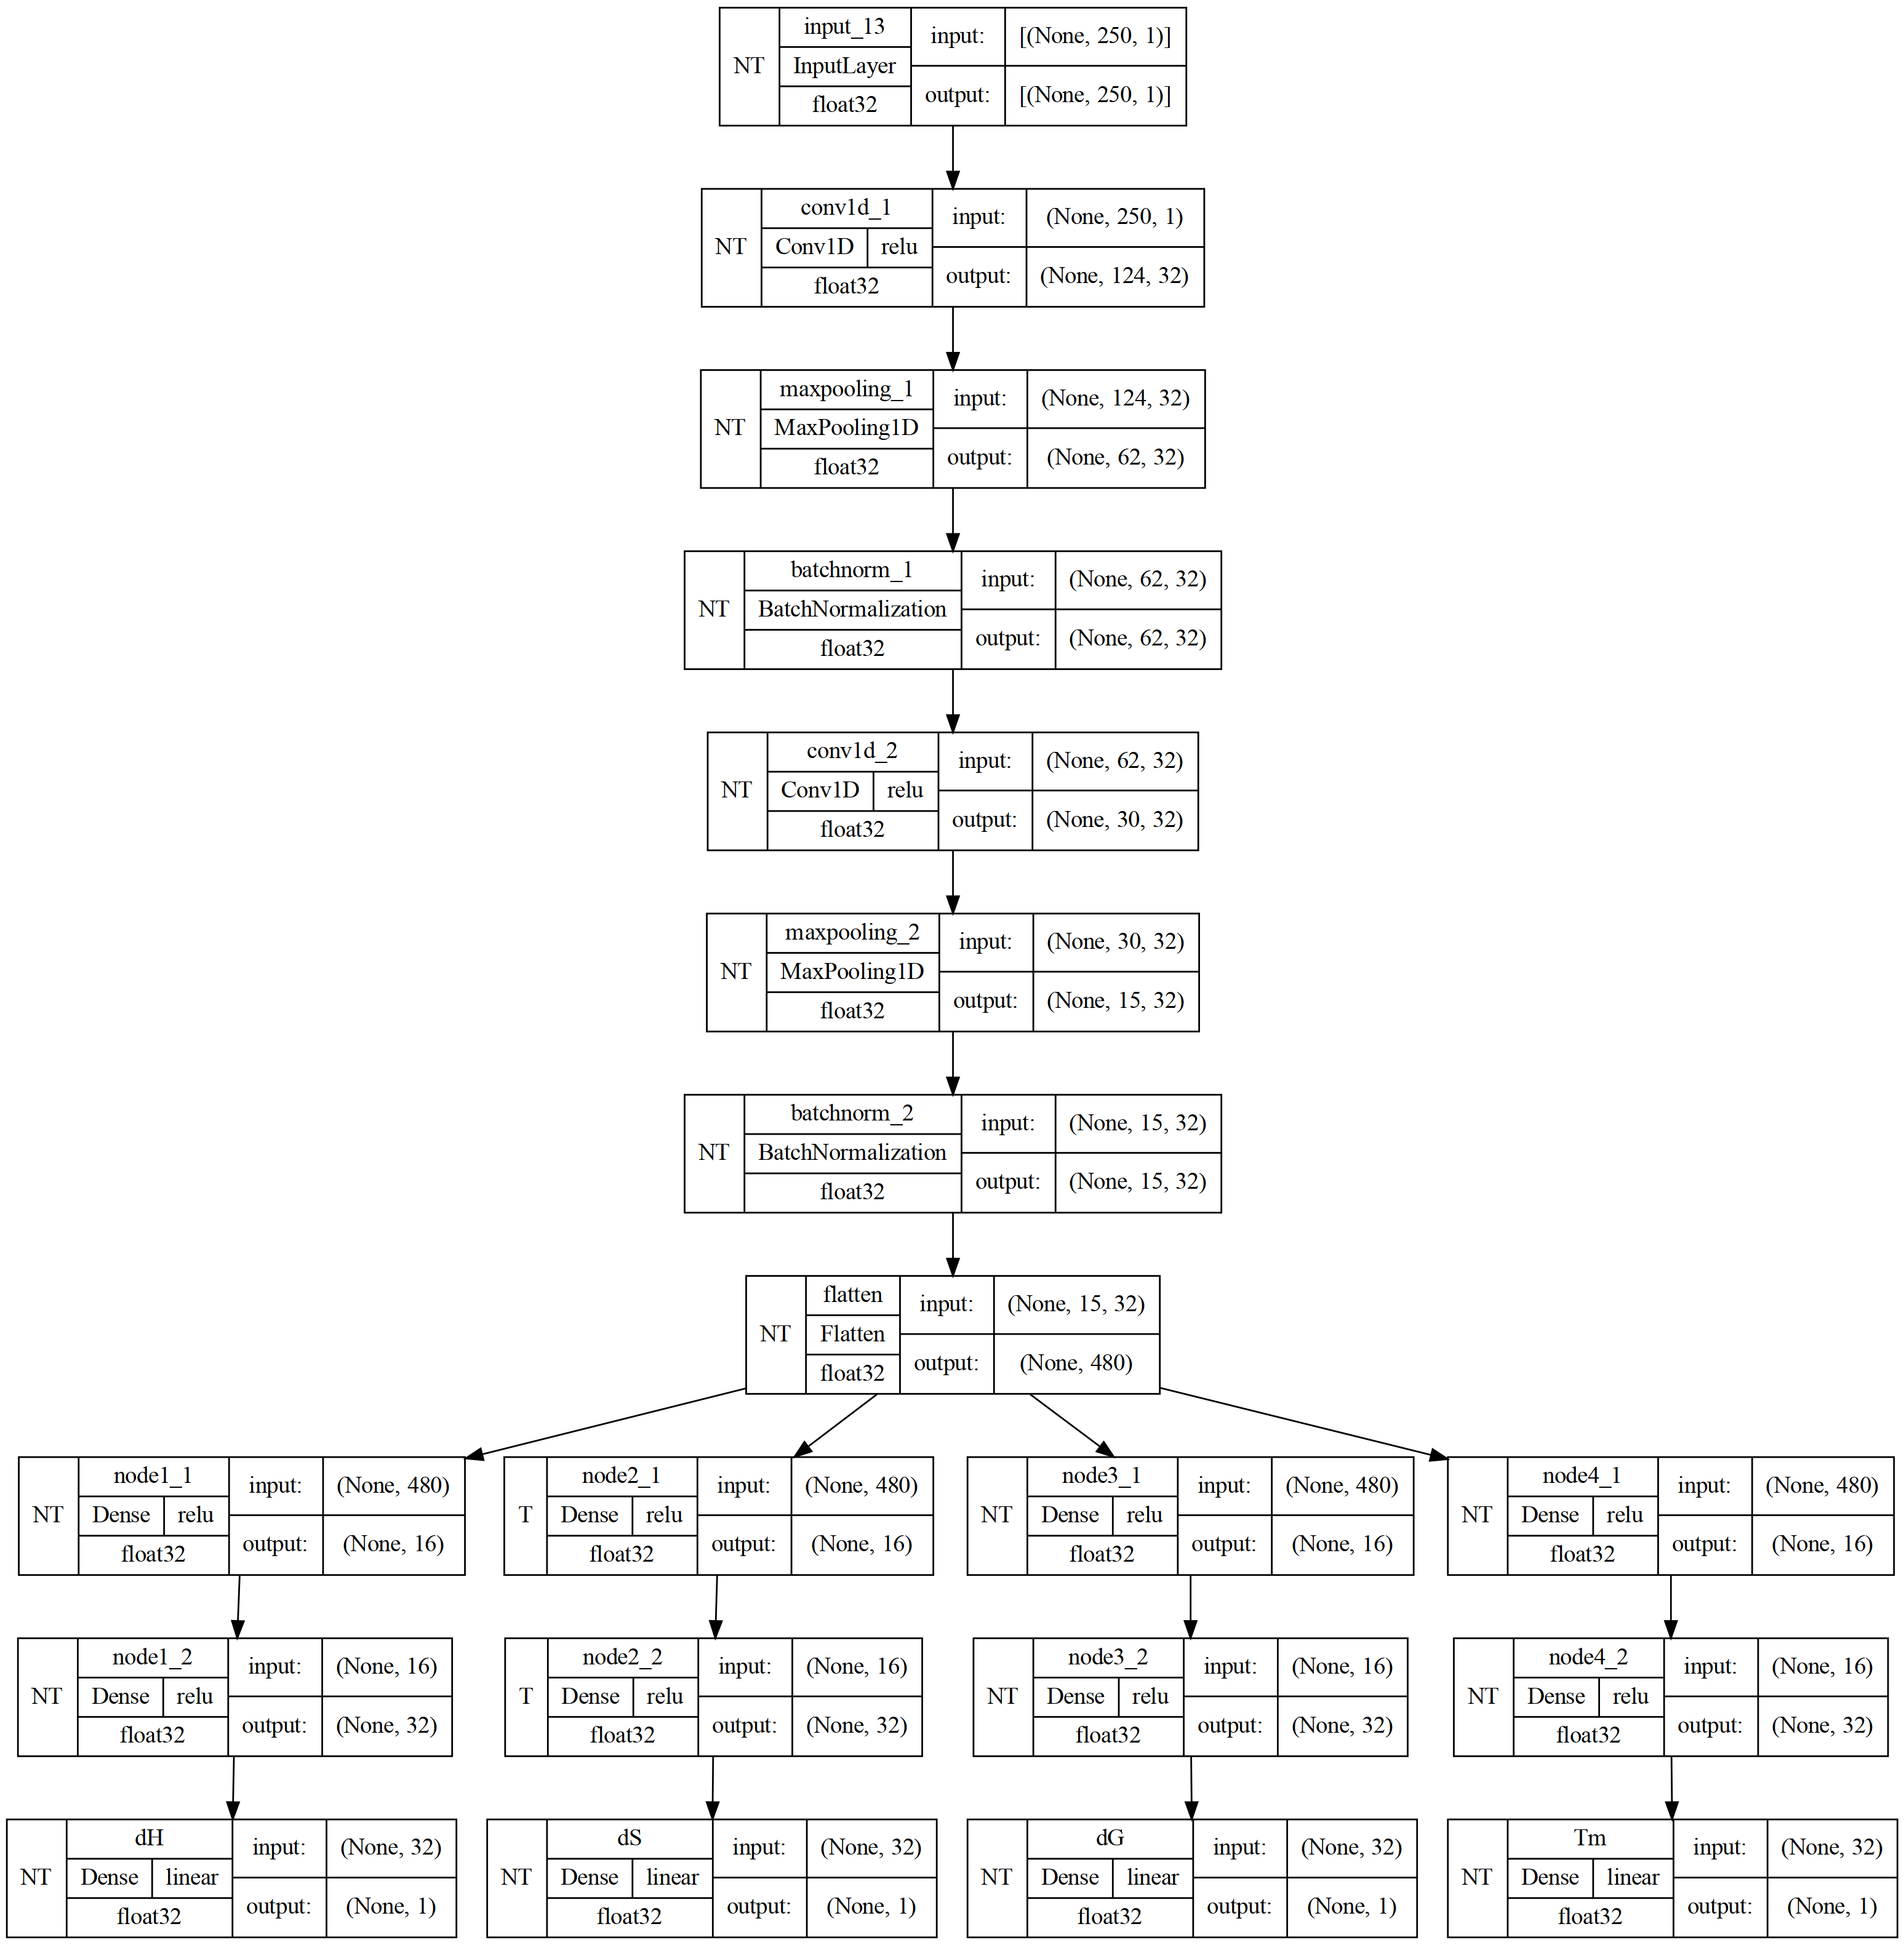

In [92]:
plot_model(model2, to_file = 'model3.png',
          show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,
)

In [37]:
model2.layers

In [44]:
!pip install pydot

In [45]:
!pip install graphviz

In [ ]:
!conda install graphviz
!y

In [46]:
!conda info --envs

# conda environments:
#
base                     /opt/software/anaconda/python-3.9.7/2021.11
test                     /opt/software/anaconda/python-3.9.7/2021.11/envs/test
tf                    *  /users/qdb16186/.conda/envs/tf
tf2                      /users/qdb16186/.conda/envs/tf2



In [52]:
!pip install pydotplus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 3.4 MB/s eta 0:00:00m eta 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24552 sha256=7bfd0ff34937f06ba99d4703ef56e8dd160f8f02b6d3b1d0cabeabe04c3914e7
  Stored in directory: /users/qdb16186/.cache/pip/wheels/89/e5/de/6966007cf223872eedfbebbe0e074534e72e9128c8fd4b55eb
Successfully built pydotplus


/bin/bash: /bin/sudo: Permission denied


In [151]:
# model2.get_weights()
model2.save_weights(f"{os.getcwd()}/test/test.cpk")

In [152]:
model3=build_model()
model3.load_weights(f"{os.getcwd()}/test/test.cpk")

In [154]:
y_test_pred = model2.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')
    

2/2 [==============================] - 0s 3ms/step
dH: r2=0.928, rmsd=6.600, mse=43.563, mae=5.132
dS: r2=0.913, rmsd=19.455, mse=378.502, mae=15.228
dG: r2=0.950, rmsd=0.988, mse=0.975, mae=0.742
Tm: r2=0.870, rmsd=4.874, mse=23.758, mae=3.674


In [153]:
model3

In [155]:
y_test_pred = model3.predict(X_padded_test)
# y_test_pred
prop = ['dH','dS','dG','Tm']
for n in range(4):
    
    r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred[n], Y_test, prop[n])
    print(f'{prop[n]}: r2={r2}, rmsd={rmsd}, mse={mse}, mae={mae}')
    

2/2 [==============================] - 0s 4ms/step
dH: r2=0.928, rmsd=6.600, mse=43.563, mae=5.132
dS: r2=0.913, rmsd=19.455, mse=378.502, mae=15.228
dG: r2=0.950, rmsd=0.988, mse=0.975, mae=0.742
Tm: r2=0.870, rmsd=4.874, mse=23.758, mae=3.674


In [157]:
store_df=pd.DataFrame()

In [160]:
prop[n]

'Tm'

In [162]:
for n in range(4):
    store_df[f'true_{prop[n]}'] = Y_test[f'{prop[n]}']

for n in range(4):
    store_df[f'pred_{prop[n]}'] = y_test_pred[n]

In [163]:
store_df

,true_dH,true_dS,true_dG,true_Tm,pred_dH,pred_dS,pred_dG,pred_Tm
7,-52.4,-146.0,-7.1,32.2,-58.497154,-163.608185,-7.701569,37.141209
9,-50.2,-143.0,-6.0,27.0,-55.096191,-156.436844,-6.426764,32.363731
17,-56.2,-151.0,-9.3,45.0,-58.043678,-162.015137,-7.913347,37.387241
21,-47.2,-128.0,-7.5,34.1,-55.865150,-158.537445,-6.663093,32.498135
22,-49.8,-134.0,-8.2,41.5,-59.314575,-165.573303,-8.165701,38.538620
24,-123.9,-335.0,-19.9,70.4,-111.313019,-301.635040,-17.727169,67.300087
42,-62.0,-170.0,-9.4,46.0,-60.921051,-168.633911,-8.763830,40.619907
49,-68.0,-196.0,-7.2,33.7,-64.010612,-186.320221,-6.683361,31.028843
50,-59.0,-172.0,-5.7,25.4,-57.103489,-165.194427,-6.081664,29.231810
52,-68.4,-193.0,-8.6,39.7,-71.801071,-206.676895,-8.364224,36.988953
